In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations

log_file = "C:\\Users\\ekuep\\Desktop\\ols_logs_aggreg.txt"
csv_file = "C:\\Users\\ekuep\\Desktop\\rsquared_values.csv"
file_path = "Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Rhythmic Stimulation Gait Similarity Project\\Analysis and Results\\Updated_DataSplitting\\GPS\\3Levels_Trial1\\logresults_22-07-24_11-20.csv"


In [ ]:
#For each participant, applies a regression across change in stance time symmetry to change in similarity score
#Runs through all combinations of algorithms and sensor combinations.

data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['X'] = pd.to_numeric(data['X'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')


def percent_difference(values):
    base_value = values.iloc[0]  # Take the first value as base
    return [math.ceil(abs(value - base_value)) for value in values]

def plot_scatter_and_regress(data, algorithm, participant, sensor):
    subset = data[(data['Algorithm'] == algorithm) & 
                  (data['Participant'] == participant) & 
                  (data['Sensor'] == sensor)]
    #print(f'Generating plot and regression for {algorithm}, {participant}, {sensor}, number of data points: {len(subset)}')
    
    if not subset.empty:
        subset['Percent_Difference'] = percent_difference(subset['X'])
        X = subset['Percent_Difference'].values
        subset['Ydiff'] = subset['Y'] - subset['Y'].iloc[0]
        Y = subset['Ydiff'].values
        subset_df = pd.DataFrame({'X': X, 'Y': Y})
        model = ols('Y~X',data=subset_df)
        results = model.fit()

        # with open(log_file, 'a') as f:
        #     f.write(f'Regression results for {algorithm}, {participant}, {sensor}:\n')
        #     f.write(results.summary().as_text() + '\n\n')
        
        # rsquared = results.rsquared
        
        # with open(csv_file, 'a') as f:
        #     f.write(f'{algorithm},{participant},{sensor},{rsquared}\n')    
            
        # #print(results.summary2())
        # plt.figure()
        # plt.scatter(X, Y, label=f'{algorithm}-{participant}-{sensor}')
        # sns.regplot(x='X',y='Y',data = subset_df,ci=None)
        # plt.text(x=subset_df['X'].min(), y=subset_df['Y'].max(), s=f'$R^2 = {rsquared:.2f}$')
        # plt.xticks(X)
        # plt.ylabel('Change in Similarity')
        # plt.xlabel('% Change in Stance Time Symmetry')
        # plt.title(f'Scatter Plot and Regression for {algorithm}, {participant}, {sensor}')
        # plt.savefig(f'C:\\Users\\ekuep\Desktop\\{algorithm}-{participant}-{sensor}.png')
        
    else:
        print(f'No data available for {algorithm}, {participant}, {sensor}')

participants = data['Participant'].unique()
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

for participant in participants:
    for sensor in sensors:
        for algorithm in algorithms:
            plot_scatter_and_regress(data, algorithm, participant, sensor)


In [ ]:
#Aggregates participants together for a given algorithm and sensor config result. Options for computing SRM, Cohen's d, Welch's t-test, etc.
file_path = r"C:\GP-WearablesAnalysis\examples\GPS_0805.csv"
data = pd.read_csv(file_path,header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
#data['X'] = pd.to_numeric(data['X'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

def calculate_srm(col1, col2):
    # Filter out None values
    valid_indices = ~col1.isna() & ~col2.isna()
    if np.any(valid_indices):
        mean_diff = np.mean(col1[valid_indices] - col2[valid_indices])
        std_diff = np.std((col1[valid_indices] - col2[valid_indices]),ddof=1)
        return mean_diff / std_diff
    else:
        return np.nan  # Return NaN if no valid values are present

def calculate_cohens_d(group1, group2):
    mean_diff = mean(group1) - mean(group2)
    pooled_std = np.sqrt((stdev(group1)**2 + stdev(group2)**2) / 2)
    return mean_diff / pooled_std

# Function to plot scatter plots and regression
def plot_scatter_and_regress(data, algorithm, sensor, csv_file):
    
    csv_file = r"C:\GP-WearablesAnalysis\examples\GPS_0805_SRM.csv"
    csv_file2 = r"C:\GP-WearablesAnalysis\examples\GPS_0805_ttest.csv"
    csv_file3 = r"C:\GP-WearablesAnalysis\examples\GPS_0805_cohensd.csv"
    
    subset = data[(data['Algorithm'] == algorithm) & 
                  (data['Sensor'] == sensor)]
    print(f'Generating plot and regression for {algorithm}, {sensor}, number of data points: {len(subset)}')
    
    if not subset.empty:
        
        # df = pd.DataFrame(columns=['0', '0.03', '0.06'], index=range(10))  # Initialize outside the loop
        # df2 = pd.DataFrame(columns=['0', '0.03', '0.06'], index=range(10))  # Initialize outside the loop
        
        df = pd.DataFrame(columns=['Baseline', '0', '1','2'], index=range(len(subset['Participant'].unique())))  # Initialize outside the loop
        df2 = pd.DataFrame(columns=['Baseline', '0', '1','2'], index=range(len(subset['Participant'].unique())))  # Initialize outside the loop
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
            Y = participant_data['Y'].values.tolist()
            Y_diff = participant_data['Y_diff'].values.tolist()
            
            # df.loc[i] = Y
            # df2.loc[i] = Y_diff
            if len(Y) == 3:
                df.loc[i] = Y + [None]  # Add None to make it 4 elements
                df2.loc[i] = Y_diff + [None]
            elif len(Y) == 4:
                df.loc[i] = Y
                df2.loc[i] = Y_diff
        
        print(df)
        srm_results = {}
        t_test_results = {}
        cohen_d_results = {}
        
        start_column = 'Baseline'
        for col in df.columns:
            if col != start_column and not df[col].isna().all():  # Ignore '0%' column and columns with all None values
                # Ensure numeric data and drop NaNs
                data1 = df[start_column].dropna().astype(float)
                data2 = df[col].dropna().astype(float)
                
                # Calculate SRM
                srm_value = calculate_srm(data1, data2)
                srm_results[col] = srm_value
                
                # # Perform Welch's t-test
                # t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
                # t_test_results[col] = {'t_statistic': t_stat, 'p_value': p_val}
                
                # Calculate Cohen's d
                # cohen_d = calculate_cohens_d(data1, data2)
                # cohen_d_results[col] = cohen_d
        
        columns = [col for col in df.columns if not df[col].isna().all()]

        # Check if columns list is correct
        print(f"Columns for comparison: {columns}")

        # Generate all unique pairs of columns
        pairs = list(combinations(columns, 2))
        excluded_pairs = [('0', '1'), ('0', '2')]
        filtered_pairs = [pair for pair in pairs if pair not in excluded_pairs]
        # Check if pairs list is correct
        print(f"Pairs for comparison: {pairs}")
        for col1, col2 in filtered_pairs:
            # Ensure numeric data and drop NaNs
            data1 = df[col1].dropna().astype(float)
            data2 = df[col2].dropna().astype(float)

            # Perform Welch's t-test
            t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
            t_test_results[f'{col1}_vs_{col2}'] = {'t_statistic': t_stat, 'p_value': p_val}
            
        print("T-Test Results:", t_test_results)               
        #Append results to CSV file
        with open(csv_file, "a") as csv_file:
            for key, value in srm_results.items():
                csv_file.write(f"{algorithm},{sensor},{key},{value}\n") 
        
        with open(csv_file2, "a") as csv_file2:
            for key, value in t_test_results.items():
                csv_file2.write(f"{algorithm},{sensor},{key},{value}\n") 
                
        with open(csv_file3, "a") as csv_file3:
            for key, value in cohen_d_results.items():
                csv_file3.write(f"{algorithm},{sensor},{key},{value}\n") 
        
        #Use the second dataframe for the plotting        
        mean_values = df2.mean()
        sem_values = df2.sem()  # Standard error of the mean
        x_labels = df.columns
        plt.figure(figsize=(6,4))
        # plt.errorbar(x_labels[1:], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o', capsize=15, linewidth=5,markersize=10,capthick=5) #font size 26 -- option used to generate figures for pres.
        plt.errorbar(x_labels[1:], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o',capsize=5, color='black')
        #plt.plot(x_labels[1:], mean_values[1:], linestyle='-', color='black')
        plt.xlabel('Δ STSR')
        plt.ylabel('Δ Similarity')
         #Adjust title based on conditions

        if sensor == "upper":
            title_sensor = "Upper Leg"

        if sensor == "lower":
            title_sensor = "Lower Leg"
        else:
            title_sensor = sensor
        
        if algorithm == "HMM-SM":
            title_algorithm = "HMM"

        else:
            title_algorithm = algorithm
        plt.title(f"Algorithm: {title_algorithm}, Sensor: {title_sensor}")
        
        # plt.yticks(fontsize=18)
        # plt.xticks(fontsize=18)
        
        plt.tick_params(axis='y')
        plt.tick_params(axis='x')
    
        plt.tight_layout()
        #plt.savefig(f"C:\\Users\\ekuep\\Desktop\\changefrombaseline_STSR_{algorithm}_{sensor}.png")  # Save plot
        
# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Plot for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        plot_scatter_and_regress(data, algorithm, sensor, csv_file)

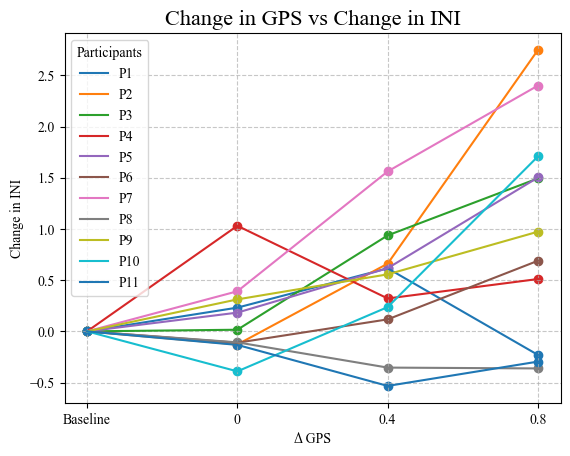

     Baseline          0          1          2
0    8.015185   8.247012    8.63083   7.785027
1    8.343197   8.214969   9.004593  11.091564
2     8.96967   8.985637    9.90693  10.463533
3    10.51421  11.545269  10.835531  11.025309
4    9.309639   9.492667   9.926642  10.812325
5    12.16181   12.05084  12.278981  12.851356
6    9.154749   9.546275  10.716612  11.555085
7    8.313672   8.206374   7.959908   7.951747
8    7.770265   8.082572   8.327181   8.743697
9   14.689819  14.299296  14.926966  16.398899
10   8.650897   8.518745   8.118179   8.355716
{'0': -0.30859714850983616, '1': -0.7426638503329425, '2': -0.9487268815709058}
Columns for comparison: ['Baseline', '0', '1', '2']
Pairs for comparison: [('Baseline', '0'), ('Baseline', '1'), ('Baseline', '2'), ('0', '1'), ('0', '2'), ('1', '2')]
T-Test Results: {'Baseline_vs_0': {'t_statistic': -0.1339510654085856, 'p_value': 0.8947814326049933}, 'Baseline_vs_1': {'t_statistic': -0.48170289516862763, 'p_value': 0.6352459371567706}

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations

# Define the SRM calculation function
def calculate_srm(col1, col2):
    # Filter out None values
    valid_indices = ~col1.isna() & ~col2.isna()
    if np.any(valid_indices):
        mean_diff = np.mean(col1[valid_indices] - col2[valid_indices])
        std_diff = np.std((col1[valid_indices] - col2[valid_indices]), ddof=1)
        return mean_diff / std_diff
    else:
        return np.nan  # Return NaN if no valid values are present


file = r"C:\GP-WearablesAnalysis\examples\logresults_GPS_INI_BaselineControl06-08-24_15-50.csv"
file.replace("\\", "/")
data = pd.read_csv(file,header=None)
data.columns = ['FilePath', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['X'] = pd.to_numeric(data['X'], errors='coerce')
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
columns=['Baseline','0', '1','2']
df = pd.DataFrame(columns=['Baseline','0', '1','2'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
df2 = pd.DataFrame(columns=['Baseline','0', '1','2'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
for i, participant in enumerate(data['Participant'].unique()):
    participant_data = data[data['Participant'] == participant].copy()
    participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
    Y = participant_data['Y'].values.tolist()
    Y_diff = participant_data['Y_diff'].values.tolist()
    X = participant_data['X'].values.tolist()
    X_diff = participant_data['X'] - participant_data['X'].iloc[0]

    if len(Y) < len(columns):
        df.loc[i] = Y + [None]  # Add None to make it 4 elements
        df2.loc[i] = Y_diff + [None]
    else:
        df.loc[i] = Y
        df2.loc[i] = Y_diff
        
        
    columns=['Baseline','0', '0.4','0.8']
    #plt.plot(Y_diff)
    plt.scatter(columns, Y_diff)
    plt.plot(columns,Y_diff,label=f"P{i+1}")
    


#plt.ylim([0,10]) 
plt.legend()
plt.xlabel("Δ GPS")
plt.ylabel("Δ INI")   
plt.grid(True, linestyle='--', alpha=0.7)

# Customize x and y ticks for better readability
plt.xticks(columns)
plt.yticks(fontsize=10)
plt.title("Change in GPS vs Change in INI", fontsize=16)
# Add legend
plt.legend(title="Participants")
plt.show()

print(df)
srm_results = {}
t_test_results = {}
cohen_d_results = {}

start_column = 'Baseline'
for col in df.columns:
    if col != start_column and not df[col].isna().all():  # Ignore '0%' column and columns with all None values
        # Ensure numeric data and drop NaNs
        data1 = df[start_column].dropna().astype(float)
        data2 = df[col].dropna().astype(float)
        
        # Calculate SRM
        srm_value = calculate_srm(data1, data2)
        srm_results[col] = srm_value
        
        # # Perform Welch's t-test
        # t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
        # t_test_results[col] = {'t_statistic': t_stat, 'p_value': p_val}
        
        # Calculate Cohen's d
        # cohen_d = calculate_cohens_d(data1, data2)
        # cohen_d_results[col] = cohen_d
print(srm_results)
columns = [col for col in df.columns if not df[col].isna().all()]

# Check if columns list is correct
print(f"Columns for comparison: {columns}")

# Generate all unique pairs of columns
pairs = list(combinations(columns, 2))
#excluded_pairs = [('0', '1'), ('0', '2')] #Don't need the comparisons to the second baseline group
#excluded_pairs = [('0', '1')]
#filtered_pairs = [pair for pair in pairs if pair not in excluded_pairs]
filtered_pairs = [pair for pair in pairs]
# Check if pairs list is correct
print(f"Pairs for comparison: {pairs}")
for col1, col2 in filtered_pairs:
    # Ensure numeric data and drop NaNs
    data1 = df[col1].dropna().astype(float)
    data2 = df[col2].dropna().astype(float)

    # Perform Welch's t-test
    t_stat, p_val = ttest_ind(data1, data2, equal_var=False)
    t_test_results[f'{col1}_vs_{col2}'] = {'t_statistic': t_stat, 'p_value': p_val}
    
print("T-Test Results:", t_test_results)               

#Append results to CSV file
csv_file =r"C:\GP-WearablesAnalysis\examples\logresults_GPS_INI_BaselineControl06-08-24_15-50_SRM.csv"
csv_file.replace("\\", "/")
with open(csv_file, "a") as csv_file:
    for key, value in srm_results.items():
        csv_file.write(f"{key},{value}\n") 

csv_file2 =r"C:\GP-WearablesAnalysis\examples\logresults_GPS_INI_BaselineControl06-08-24_15-50_ttest.csv"
csv_file2.replace("\\", "/")
with open(csv_file2, "a") as csv_file2:
    for key, value in t_test_results.items():
        csv_file2.write(f"{key},{value}\n") 
                
                